In [688]:
import pandas as pd
import numpy as np
import pythainlp
import pickle
import tensorflow as tf
import re
import emoji
import matplotlib.pyplot as plt

from pythainlp.corpus.common import thai_stopwords
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, load_model
from keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D, Dropout
from keras.utils import pad_sequences
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

ModelCheckpoint = tf.keras.callbacks.ModelCheckpoint
ReduceLROnPlateau = tf.keras.callbacks.ReduceLROnPlateau

['ไร อะ' 'อ้าว อยาก มีเรื่อง หรอ วะ ไอ้ หัว เกรียน' 'ขอโทษ ที่ รบกวน คะ']
['neutral' 'negative' 'positive']
maxlen:  128


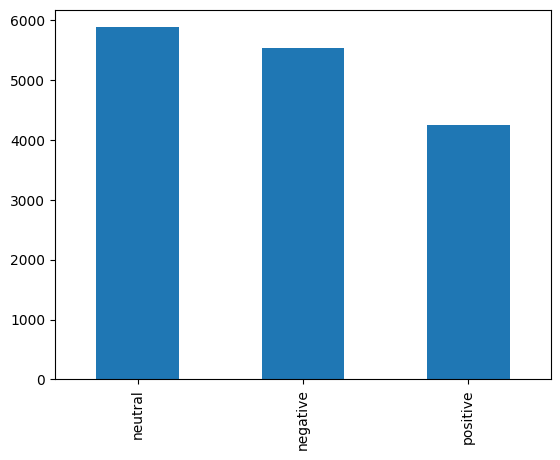

In [685]:
# Set the maximum number of words to keep based on word frequency
max_words = 10000
# Load the data from the CSV file
df = pd.read_csv('C:/Sentiment-Analysis-Model/datasets/datasetTH.csv')
data = df.drop_duplicates().copy()  # Make a copy of the DataFrame

df['sentiment'].value_counts().plot.bar()

# Define preprocess for Thai text
def preprocess_text(text):
    # tokenize the text
    text = emoji.demojize(text)
    text = "".join(u for u in text if u not in ("?", ".", ";", ":", "!", '"', "ๆ", "ฯ"))
    text = re.sub(r'[a-zA-Z]', '', text)  # Remove English characters
    text = " ".join(word for word in text)
    text = "".join(word for word in text.split() if word.lower() not in thai_stopwords())
    tokens = pythainlp.word_tokenize(str(text), engine='newmm')
    # join the tokens back into a single string
    text = " ".join(tokens)
    # remove non-alphabetic characters and extra whitespaces
    text = re.sub('[^A-Za-zก-๙]+', ' ', text).strip()
    return text

# Apply the preprocessing function to the 'text' column using loc
data.loc[:, 'text'] = data['text'].apply(preprocess_text)

print(data['text'].values[:3])
print(data['sentiment'].values[:3])

# Split the data into text and labels
x = data['text'].values
y = data['sentiment'].values

# Convert the sentiment labels to one-hot encoded vectors
y = pd.get_dummies(y).values

# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# Create the Tokenizer object without passing a custom tokenizer function
tokenizer = Tokenizer(num_words=max_words, filters='', lower=False, oov_token='<UNK>')
tokenizer.fit_on_texts(x_train)
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

# The rest of the code remains the same
maxlen = max([len(x) for x in x_train])
print('maxlen: ', maxlen)
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)



In [691]:
# Create the model
model = Sequential()
model.add(Embedding(max_words, 128, input_length=maxlen))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_49 (Embedding)    (None, 128, 128)          1280000   
                                                                 
 conv1d_52 (Conv1D)          (None, 124, 128)          82048     
                                                                 
 global_max_pooling1d_49 (Gl  (None, 128)              0         
 obalMaxPooling1D)                                               
                                                                 
 dense_50 (Dense)            (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_51 (Dense)            (None, 3)                 195       
                                                     

In [693]:
# Train the model
filename = 'sentiment_analysis_model2.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.1, min_lr=0.000001)
callbacks_list = [checkpoint, learning_rate_reduction]

model.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(x_test, y_test), callbacks=callbacks_list)

Epoch 1/5
186/187 [============================>.] - ETA: 0s - loss: 0.7554 - accuracy: 0.6667
Epoch 1: val_loss improved from inf to 0.73533, saving model to sentiment_analysis_model2.h5
187/187 [==============================] - 12s 60ms/step - loss: 0.7549 - accuracy: 0.6669 - val_loss: 0.7353 - val_accuracy: 0.6905 - lr: 0.0010
Epoch 2/5
186/187 [============================>.] - ETA: 0s - loss: 0.5367 - accuracy: 0.7994
Epoch 2: val_loss did not improve from 0.73533
187/187 [==============================] - 13s 68ms/step - loss: 0.5370 - accuracy: 0.7994 - val_loss: 0.7380 - val_accuracy: 0.6744 - lr: 0.0010
Epoch 3/5
187/187 [==============================] - ETA: 0s - loss: 0.3873 - accuracy: 0.8594
Epoch 3: val_loss did not improve from 0.73533
187/187 [==============================] - 15s 79ms/step - loss: 0.3873 - accuracy: 0.8594 - val_loss: 0.8098 - val_accuracy: 0.6687 - lr: 0.0010
Epoch 4/5
186/187 [============================>.] - ETA: 0s - loss: 0.3015 - accuracy: 0.

In [694]:
# Load the best model
model = load_model(filename)

# Compute validation loss and accuracy
val_loss, val_accuracy = model.evaluate(x_test, y_test, verbose=0)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Predict classes for test data
y_pred = model.predict(x_test)
predicted_classes = np.argmax(y_pred, axis=1)

# Define class labels
class_labels = ['pos', 'neg', 'neu']

# Compute confusion matrix
confusion_mat = confusion_matrix(np.argmax(y_test, axis=1), predicted_classes)

# Print confusion matrix with class labels
print("Confusion Matrix:")
for i in range(len(class_labels)):
    label_row = ""
    for j in range(len(class_labels)):
        label_row += f"{class_labels[i]}: {confusion_mat[i][j]} "
    print(label_row)
    
print()

# Calculate precision, recall, and F1-score
# Get the true labels and predicted labels
y_true = np.argmax(y_test, axis=1)
y_pred = predicted_classes

# Calculate precision for each class
precision = precision_score(y_true, y_pred, average=None)

# Calculate recall for each class
recall = recall_score(y_true, y_pred, average=None)

# Calculate F1-score for each class
f1 = f1_score(y_true, y_pred, average=None)

# Print precision, recall, and F1-score for each class
for i in range(len(class_labels)):
    print(f"Class: {class_labels[i]}")
    print("Precision:", precision[i])
    print("Recall:", recall[i])
    print("F1-score:", f1[i])
    print()

Validation Loss: 0.7353342771530151
Validation Accuracy: 0.6904761791229248
94/94 [==============================] - 1s 8ms/step
Confusion Matrix:
pos: 804 pos: 116 pos: 54 
neg: 158 neg: 857 neg: 180 
neu: 126 neu: 289 neu: 398 

Class: pos
Precision: 0.7389705882352942
Recall: 0.8254620123203286
F1-score: 0.7798254122211447

Class: neg
Precision: 0.679080824088748
Recall: 0.7171548117154811
F1-score: 0.6975986975986975

Class: neu
Precision: 0.629746835443038
Recall: 0.48954489544895446
F1-score: 0.5508650519031141



In [720]:
# Save the trained model and the tokenizer to disk
model.save('sentiment_analysis_model.h5')
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle)

In [721]:
#load model and tokenizer
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

model = load_model('sentiment_analysis_model.h5')

In [730]:
new_text = 'แก้ไขด้วยอัพเดทแล้วค้าง'
new_text = preprocess_text(new_text)
print('new_text:', new_text)
new_text = tokenizer.texts_to_sequences([new_text])  # Convert text to sequences of integers
new_text = pad_sequences(new_text, maxlen=maxlen)
# Make the prediction
prediction = model.predict(new_text)[0]

# Get the predicted sentiment and confidence level
sentiments = ['Negative', 'Neutral', 'Positive']
sentiment = sentiments[np.argmax(prediction)]
confidence = np.max(prediction)

# Display the result
print(f'{sentiment} ({confidence * 100:.2f}%)')

new_text: แก้ไข ด้วย อัพเดท แล้ว ค้าง
1/1 [==============================] - 0s 62ms/step
Negative (50.25%)
